# Strength predictions using DFT indicator (predictor) properties
Ben Jasperson
2023-09-12

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from strength_covariance.model_selection import basic_outlier_removal
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model, svm
from sklearn.utils import resample
from sklearn.metrics import r2_score
from scipy import stats

Only use the indicator properties/predictors which we have DFT data for.

In [94]:
params_list_full = ['bulk_modulus_fcc',
                    'c44_fcc',
                    'surface_energy_111_fcc',
                    'unstable_stack_energy_fcc',
                    'intr_stack_fault_energy_fcc']  # for dft

Note that we do "basic outlier removal" for canonical properties, which is the same as what is done for the paper.

In [95]:
def initialize_model():
    df_in = pd.read_csv("./data/models_w_props.csv")
    df_in = df_in.drop([i for i in df_in.columns if 'diamond' in i], axis=1)

    if 'disqualified' in df_in.columns:
        df_in = df_in.drop('disqualified', axis=1)

    df_in = df_in.drop([i for i in df_in.columns if 'diamond' in i], axis=1)
    df_in = df_in.drop(['thermal_expansion_coeff_bcc',
                        'surface_energy_100_bcc',
                        'surface_energy_110_bcc',
                        'surface_energy_111_bcc',
                        'surface_energy_121_bcc'], axis=1)

    df_clean = basic_outlier_removal(df_in)

    # set parameters
    
    X = df_clean[params_list_full]
    y = df_clean['strength_MPa']

    # create pipeline
    imput = KNNImputer(n_neighbors=2, weights="uniform",
                       keep_empty_features=True)
    pca = PCA()
    #model = linear_model.LinearRegression()
    model = svm.SVR(kernel='rbf')

    pipe = Pipeline(steps=[('scale', StandardScaler()),
                           ('imp', imput),
                           ('pca', pca),
                           ('lr', model)])
    pipe = TransformedTargetRegressor(regressor=pipe,
                                      transformer=StandardScaler())

    pipe.fit(X, y)

    return df_clean, X, y, pipe


In [96]:
df_clean, X, y, pipe = initialize_model()
X.head()

,bulk_modulus_fcc,c44_fcc,surface_energy_111_fcc,unstable_stack_energy_fcc,intr_stack_fault_energy_fcc
0,104.391428,47.119833,0.038761,0.012775,0.001334
1,104.391429,47.194087,0.038761,0.012775,0.001334
2,103.740224,56.802226,0.038601,0.007298,0.000088
3,103.741350,56.845225,0.038514,0.007112,0.000082
4,103.997554,46.550733,0.053816,0.007060,0.001107


Helper function to convert surface energy units.

In [97]:
def se_unit_convert(df):
    #J/m^2 to eV/angstrom^2
    return df*6.241509e+18*1.0E-20

Import the DFT dataset and convert the surface energies

In [98]:
df_dft = pd.read_csv("./data/dft.csv")
se_list = ['surface_energy_111_fcc', 'surface_energy_112_fcc',
       'surface_energy_100_fcc', 'unstable_stack_energy_fcc',
       'intr_stack_fault_energy_fcc']
df_dft[se_list] = se_unit_convert(df_dft[se_list])
df_dft.head()

,species,bulk_modulus_fcc,c44_fcc,C11-C12,surface_energy_111_fcc,surface_energy_112_fcc,surface_energy_100_fcc,unstable_stack_energy_fcc,intr_stack_fault_energy_fcc,a0,units
0,Ag,92.8612,41.2075,31.0503,0.044252,0.050806,0.049370,0.006472,0.001067,4.1457,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const..."
1,Al,76.0248,33.6604,53.4132,0.050868,0.059045,0.058608,0.010430,0.007602,4.0378,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const..."
2,Au,144.4053,26.5289,20.9309,0.043441,0.050244,0.054176,0.005418,0.001872,4.1539,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const..."
3,Cu,133.9783,79.5973,53.4236,0.080203,0.092686,0.090315,0.011104,0.002628,3.6239,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const..."
4,Ni,206.5840,117.5921,83.1221,0.114032,0.140808,0.139810,0.017851,0.008919,3.5036,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const..."


Make a strength prediction for each species using the regression model (trained on all potentials and the indicator properties selected) and the DFT indicator properties.

In [99]:
X_dft = df_dft[params_list_full]
species_list = df_dft.species
y_dft = pipe.predict(X_dft)
dft_predicted_strength = pd.DataFrame({'species':species_list,
                                       'strength [MPa]':y_dft})
dft_predicted_strength

,species,strength [MPa]
0,Ag,807.944826
1,Al,1028.648382
2,Au,813.772657
3,Cu,1269.025660
4,Ni,2034.352762
5,Pd,1160.944855
6,Pt,1343.664503


Below is a boxplot of the IP strength values that Vasily provided, along with the strength value predicted for each species using DFT indicator properties. 

The boxplot shows the three quartile values, along with extreme values. The center line corresponds to the median of the data set, and the lower and upper quartiles are the medians of the lower and upper halves of the dataset (respectively). The whiskers extend to points that are within 1.5 IQRs of the lower and upper quartile (i.e. 1.5*(upper quartile - lower quartile)). 

More information at [Seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html) or [Wikipedia](https://en.wikipedia.org/wiki/Box_plot)

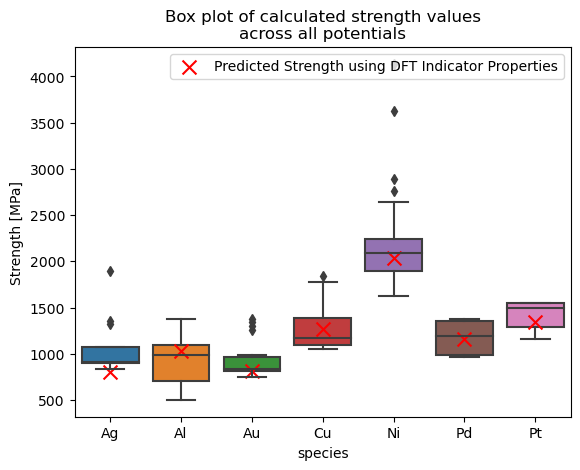

In [100]:
order_list = ["Ag","Al","Au","Cu","Ni","Pd","Pt"]
g = sns.boxplot(data = df_clean, x="species", y="strength_MPa", order=order_list)
g.set_ylabel("Strength [MPa]")
g.set_title("Box plot of calculated strength values\nacross all potentials")
g.scatter(data = dft_predicted_strength, x="species",y="strength [MPa]", marker="x", color="r", s=100, label="Predicted Strength using DFT Indicator Properties")
g.legend()

Create similar plots for each indicator property.

In [101]:
def prop_boxplot(prop):
    order_list = ["Ag","Al","Au","Cu","Ni","Pd","Pt"]
    g = sns.boxplot(data = df_clean, x="species", y=prop, order=order_list)
    g.set_ylabel(prop)
    g.set_title(f"Box plot of calculated {prop} values\nacross all potentials")
    g.scatter(data = df_dft, x="species",y=prop, marker="x", color="r", s=100, label="DFT calculated value")
    g.legend()
    return g

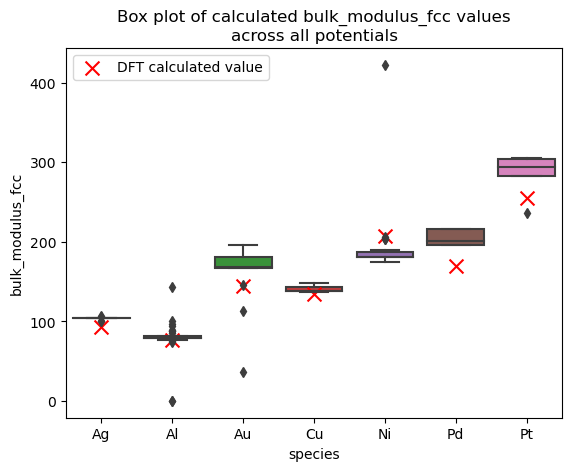

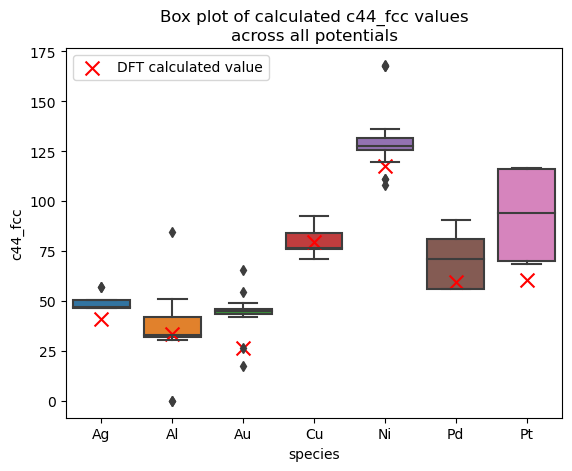

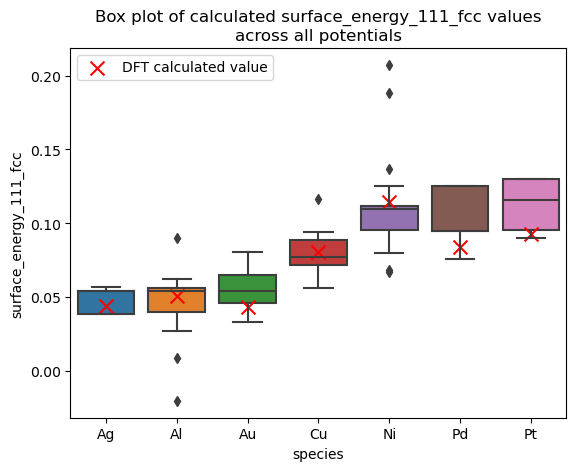

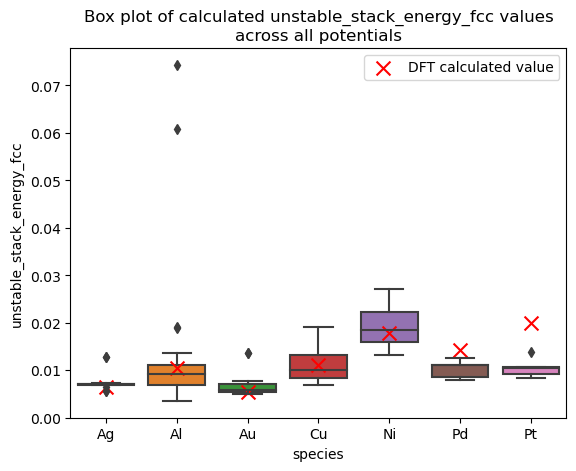

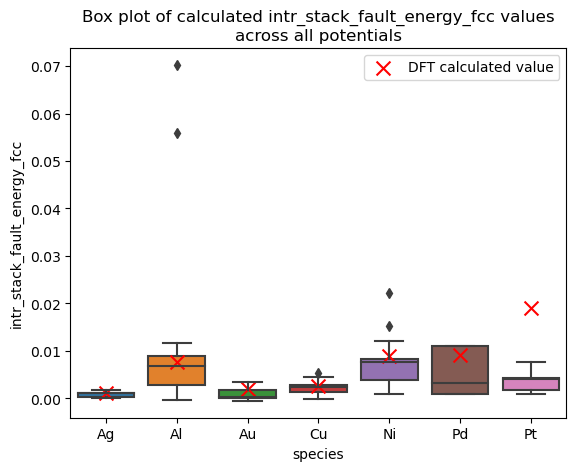

In [102]:
for param in params_list_full:
    plt.figure()
    prop_boxplot(param)